In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.t8btag_minmass
dout = "t8btag_minmass"

In [4]:
altfile = 't8btag_minmass_{base}'
use_signal = [ module.full_signal_list.index(f) for f in module.signal_list ]
signal = ObjIter([Tree(f, altfile=altfile, report=False) for f in tqdm(module.full_signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])
data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=altfile) ])


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


In [5]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [6]:
ptcut = eightb.selected_jet_pt()

btagcut = eightb.selected_jet_btagwp()

event_filter = FilterSequence(
    ptcut, btagcut
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

In [7]:
cutflow_labels = [
    "total", "trigger","met filters", "muon veto", "electron veto", "n_presel_jets >= 8", "selected_jets", "selected_jets_pt", "selected_jets_btag"
]

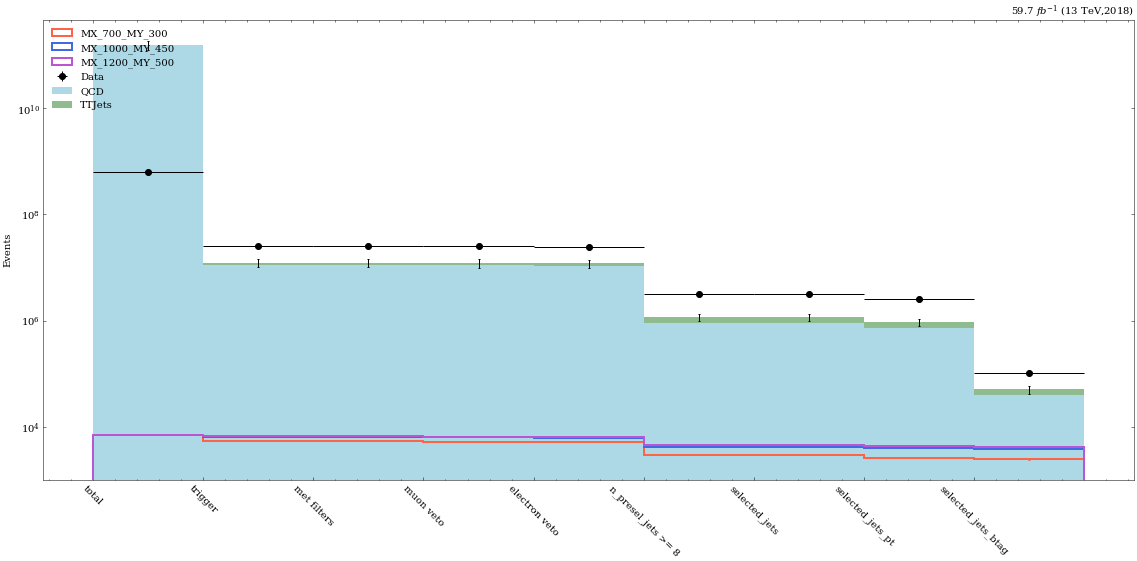

In [8]:
study.cutflow( 
    signal[use_signal] + bkg + data,
    ylim=(1e3, -1),
    xlabel=cutflow_labels,
    legend=True,
)

In [9]:
features = [
        'jet_ht','min_jet_deta','max_jet_deta','min_jet_dr','max_jet_dr'
    ] + [
        f'h{i+1}_{var}'
        for var in ('pt','dr')
        for i in range(4)
    ] + [
        f'h{i+1}{j+1}_{var}'
        for var in ('dphi','deta')
        for i in range(4)
        for j in range(i+1, 4)
    ]

100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


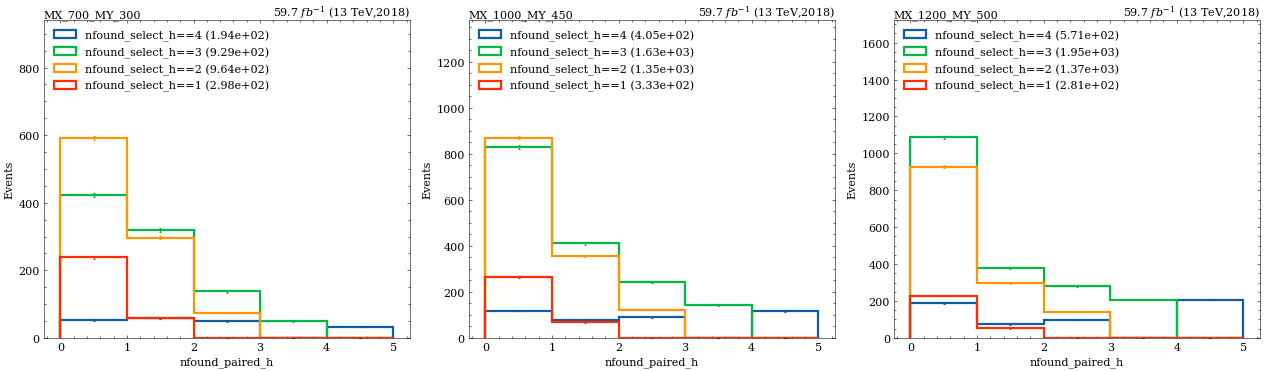

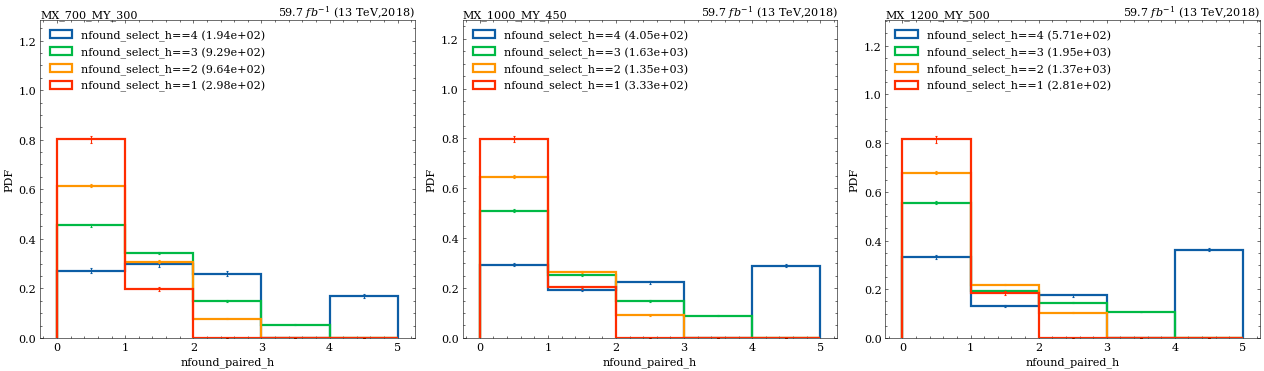

In [10]:
class nfound_select_h:
    def __init__(self, n=4):
        self.__name__ = f'nfound_select_h=={n}'
        self.n = n
    def __call__(self, t): return t.nfound_select_h==self.n

study.compare_masks( 
    signal[use_signal], 
    h_color=None, h_linestyle=None,
    legend=True,
    masks=[nfound_select_h(4), nfound_select_h(3), nfound_select_h(2), nfound_select_h(1)],
    varlist=['nfound_paired_h'],
    # efficiency=True,
)
study.compare_masks( 
    signal[use_signal], 
    h_color=None, h_linestyle=None,
    legend=True,
    masks=[nfound_select_h(4), nfound_select_h(3), nfound_select_h(2), nfound_select_h(1)],
    varlist=['nfound_paired_h'],
    efficiency=True,
)

100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


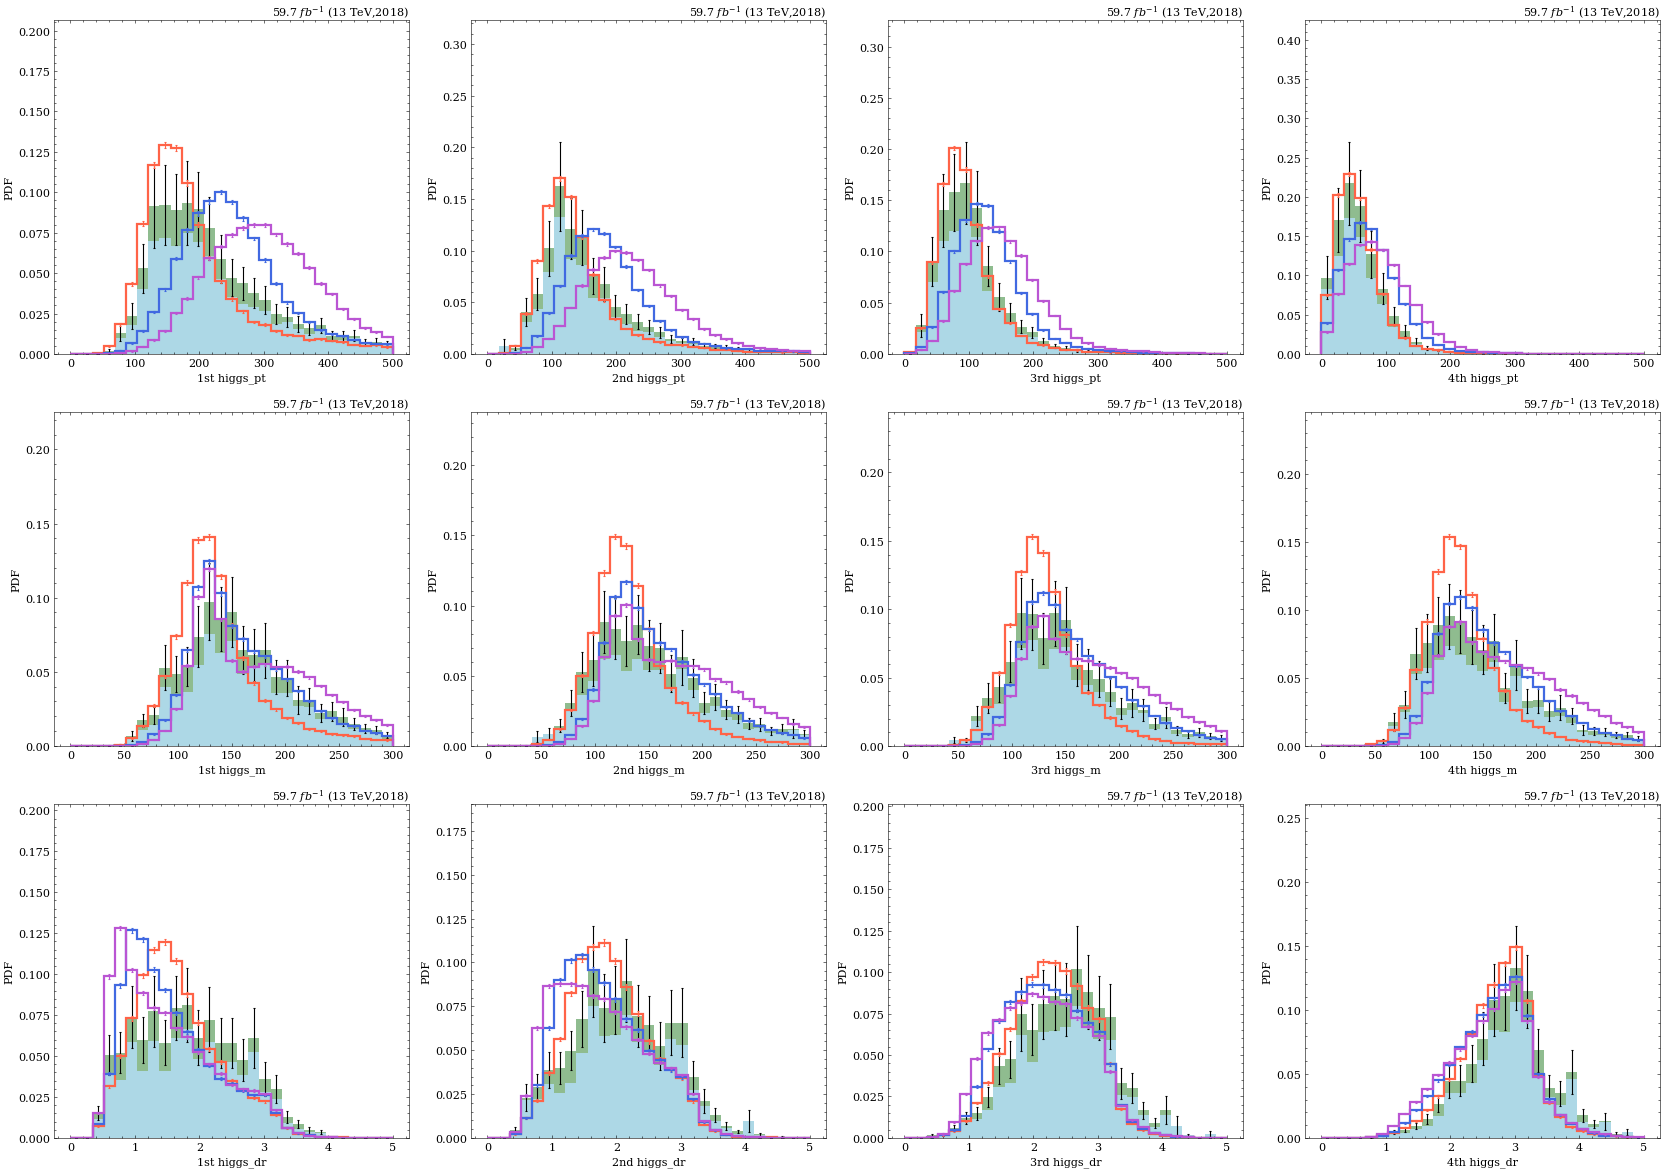

In [11]:
study.quick( 
    signal[use_signal]+bkg,
    varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','dr') for i in range(4)],
    dim=(-1, 4),
    efficiency=True,
)

100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


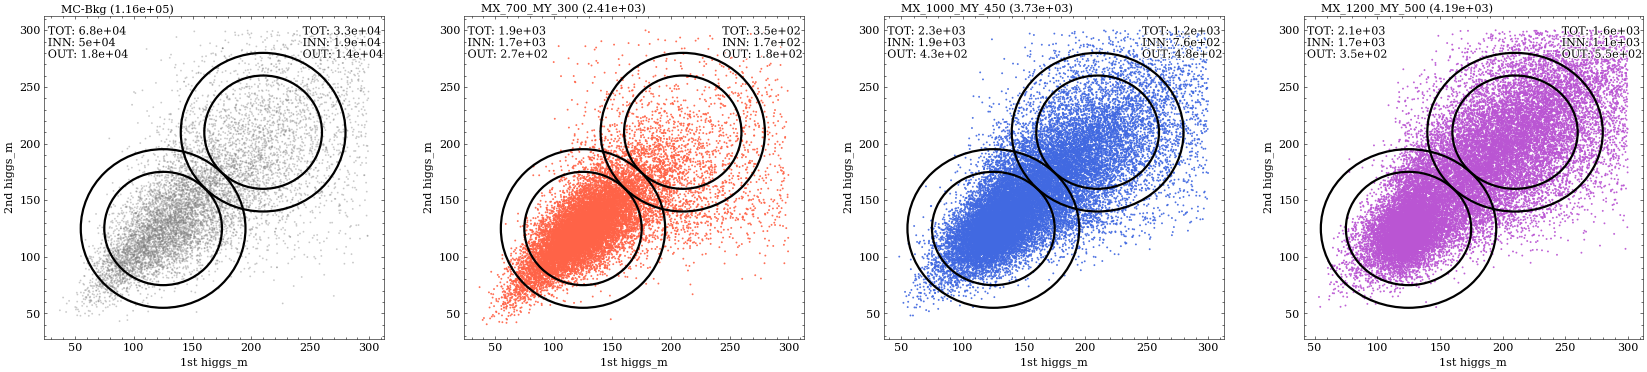

In [12]:
ar_center = [125,125]
vr_center = [210,210]
sr_r, cr_r =  50, 70

study.quick2d(
    signal[use_signal]+bkg,
    xvarlist=['higgs_m[:,0]',],
    yvarlist=['higgs_m[:,1]',],
    exe=[
        draw_concentric(*ar_center[:2], sr_r, cr_r, linewidth=2),
        draw_concentric(*vr_center[:2], sr_r, cr_r, text=(0.75,0.95), linewidth=2),
    ],
    scatter=True,
    saveas=f'{dout}/2d_higgs_space'
)

In [13]:
def higgs_dm(t, r = ar_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(higgs_dm = dm)
(signal+bkg+data).apply(higgs_dm)

# %%
def val_higgs_dm(t, r =  vr_center):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(val_higgs_dm = dm)
(signal+bkg+data).apply(val_higgs_dm)

[None, None, None, None, None, None, None, None, None, None, None]

In [14]:
ar_bdt = ABCD(
    features=features,
    a = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm < sr_r),
    b = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm < sr_r),
    c = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
    d = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm > sr_r) & (t.higgs_dm < cr_r),
)

In [15]:
blind_filter = EventFilter('blinded', filter=lambda t : ~( ar_bdt.a(t) ))
blinded_data  = data.apply(blind_filter)

In [16]:
bkg_model = blinded_data.asmodel('bkg model')

In [17]:
ar_bdt.train(bkg_model)
ar_bdt.print_results(bkg_model)

... fetching features
... splitting features
... calculating k factor
... fitting reweighter
--- ABCD Results ---
k = 3.142e-01
k*(b/a)-1  = inf%
BDT(b)/a-1 = inf%



100%|██████████| 1/1 [00:25<00:00, 25.42s/it]


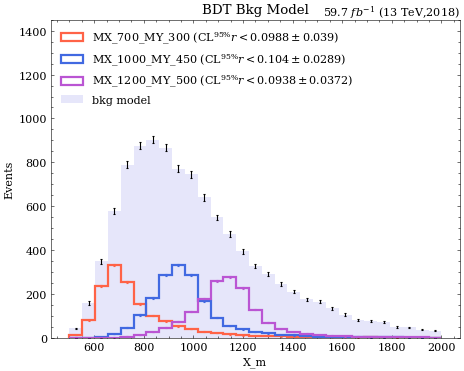

In [19]:
study.quick(
    signal[use_signal] + bkg_model, 
    legend=True,
    masks=[ar_bdt.a]*len(use_signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(use_signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'],
    binlist=[(500,2000,30)],
    title='BDT Bkg Model',
    limits=True,
    # saveas=f'{dout}/limits/bdt_bkg_model'
)

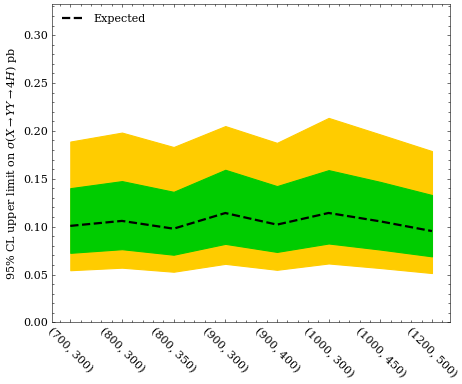

In [20]:
fig, ax = study.get_figax()

study.brazil( 
    signal + bkg_model,
    masks=[ar_bdt.a]*len(signal)+[ar_bdt.b]*len(bkg_model),
    scale=[1]*len(signal)+[ar_bdt.reweight_tree]*len(bkg_model),
    varlist=['X_m'], binlist=[(500,2000,15)],
    # use_norm=True,
    l_poi=np.linspace(0,3,21), 
    figax=(fig,ax)
    # l_saveas='~/nobackup/tmp/debug_limits_{h_sig.label}.root'
)

In [85]:
comb_nom = [1.6015625,
 1.609375,
1.3320312,
1.3085937,
 1.578125,
1.5351562,
1.6640625,
1.6328125,]

comb_m1 = [
    1.1517095,
1.1573276,
0.9578852,
0.9410309,
1.1348552,
1.1039557,
1.2006154,
1.1741819,
]

comb_p1 = [
    2.2335681,
2.2444636,
1.8523654,
1.8249887,
2.2008819,
2.1409568,
2.3207318,
2.2706415,
]

comb_m2 = [0.8633422,
0.8675537,
0.7180480,
0.7054138,
0.8507080,
0.8275451,
0.9035339,
0.8801879,]

comb_p2 = [
    2.9647986,
2.9792611,
2.4791808,
2.4392876,
2.9214115,
2.8517401,
3.1019001,
3.0284705,
]

comb_nom = np.array(comb_nom)
comb_m1 = np.array(comb_m1)
comb_p1 = np.array(comb_p1)
comb_m2 = np.array(comb_m2)
comb_p2 = np.array(comb_p2)


In [86]:
comb_sam = ["debug_limits_MX_1000_MY_300",
            "debug_limits_MX_1000_MY_450",
            "debug_limits_MX_1200_MY_500",
            "debug_limits_MX_700_MY_300",
            "debug_limits_MX_800_MY_300",
            "debug_limits_MX_800_MY_350",
            "debug_limits_MX_900_MY_300",
            "debug_limits_MX_900_MY_400"]
def get_mass(s):
    s = s.split('_')
    return [s[-3], s[-1]]
comb_mass = np.array(list(map(get_mass, comb_sam))).astype(int)

def get_mass(s):
    s = s.split('_')
    return f'({s[-3]}, {s[-1]})'
comb_sam = np.array(list(map(get_mass, comb_sam)))

In [87]:
order = comb_mass[:,0].argsort()

In [88]:
comb_nom = comb_nom[order]
comb_m1 = comb_m1[order]
comb_p1 = comb_p1[order]
comb_m2 = comb_m2[order]
comb_p2 = comb_p2[order]
comb_sam = comb_sam[order]

In [89]:
comb_std1 = (comb_p1 + comb_m1)/2
comb_std1_err = (comb_p1 - comb_m1)/2

In [90]:
comb_std2 = (comb_p2 + comb_m2)/2
comb_std2_err = (comb_p2 - comb_m2)/2

In [91]:
graph_array(comb_sam, comb_std2, yerr=comb_std2_err, fill_error=True, fill_alpha=0.25, g_color='red', figax=(fig,ax))
graph_array(comb_sam, comb_std1, yerr=comb_std1_err, fill_error=True, fill_alpha=0.25, g_color='black', figax=(fig,ax))
graph_array(comb_sam, comb_nom, figax=(fig,ax))

(<Figure size 480x400 with 1 Axes>, <AxesSubplot:>)

In [96]:
comb_nom

array([1.3085937, 1.578125 , 1.5351562, 1.6640625, 1.6328125, 1.6015625,
       1.609375 , 1.3320312])

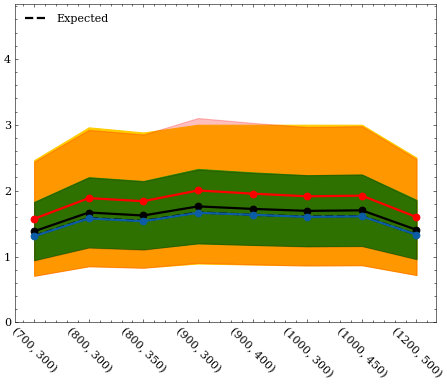

In [92]:
fig

(<Figure size 480x400 with 1 Axes>, <AxesSubplot:>)

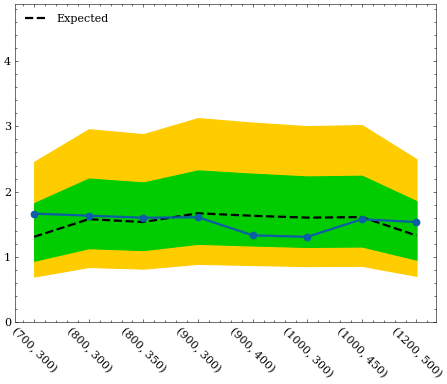

In [58]:
fig